In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV

In [2]:
def read_data(data_path, file_name):
    data = pd.read_csv(data_path+file_name, header=14)
    data = data.replace('na', np.nan)
    data['class'] = data['class'].map({'neg': 0, 'pos': 1})
    data = data.astype(float)
    for i in data.columns:
        try:
            data[i] = data[i].astype('int')
        except:
            pass
    return data

data_path = '/Users/katush/Documents/Otus/ML/L07-Feature_engineering/to_uci/'
train = read_data(data_path, 'aps_failure_training_set.csv')
test = read_data(data_path, 'aps_failure_test_set.csv')

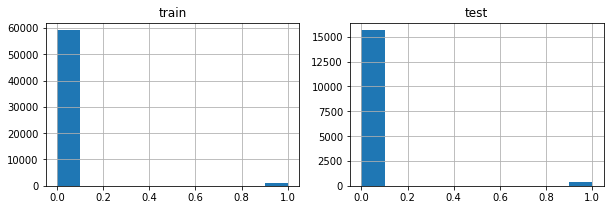

In [3]:
plt.figure(figsize=(10, 3))
plt.subplot(121, title='train')
train['class'].hist()
plt.subplot(122, title='test')
test['class'].hist()

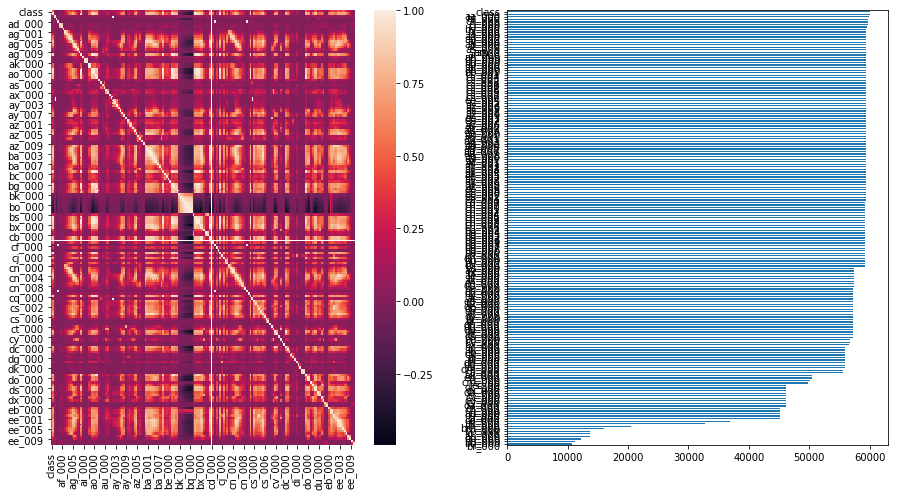

In [4]:
plt.figure(figsize=(15, 8))
plt.subplot(121)
sns.heatmap(train.corr())
plt.subplot(122)
train.count().sort_values().plot(kind='barh')

Barplots shows amount fullfillness if each row - we can drop 10 columns which filled less than 65% withput loosing much info:

In [3]:
print(train.shape)
small_data = train.columns[train.count() < train.shape[0]*0.65]
print(small_data.shape)

train = train.drop(small_data, axis=1)
test = test.drop(small_data, axis=1)

(60000, 171)
(10,)


# Feature correlation and importance

In [4]:
def corr_feature_detect(data, threshold=0.7):
    
    corrmat = data.drop(['class'], axis=1).corr()

    corrmat = corrmat.abs().unstack().sort_values(ascending=False)

    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]

    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row

        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

In [5]:
train_corr_features = corr_feature_detect(train.dropna(), threshold=0.5)
print('Amount of correlated features:', len(train_corr_features))

Amount of correlated features: 101


In [6]:
df = train.dropna()
rnd_clf = RandomForestClassifier()
rnd_clf.fit(df.drop('class', axis=1), df['class'])

imp = pd.DataFrame()
imp['feature'] = df.drop('class', axis=1).columns
imp['importance'] = rnd_clf.feature_importances_
imp = imp.sort_values('importance').reset_index(drop=True)

In [7]:
a = imp[imp['importance']< imp['importance'].quantile(0.45)]['feature']
print(len(a))
b = list(set(a) & set(train_corr_features))
print(len(b))

72
39


In [8]:
train_selected = train.drop(b, axis=1)
test_selected = test.drop(b, axis=1)

print('Amount of correlated features:', len(corr_feature_detect(train_selected.dropna(), threshold=0.5)))

Amount of correlated features: 63


In [12]:
print(train.shape, train_selected.shape)

(60000, 161) (60000, 122)


In [13]:
def scaled(X, scaler_type="minmax"):
    if scaler_type=="minmax":
        scaler = MinMaxScaler()
    elif scaler_type=="std":
        scaler = StandardScaler()
    elif scaler_type=="robust":
        scaler = RobustScaler()
        
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled

def split(train, test):
    train_wo_nan, test_wo_nan = train.dropna(), test.dropna()
    X_train, y_train = train_wo_nan.drop('class', axis=1), train_wo_nan['class']
    X_test, y_test = test_wo_nan.drop('class', axis=1), test_wo_nan['class']
    return X_train, y_train, X_test, y_test

def plot_result(result, cols=None):
    df = pd.DataFrame(result)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=df[0], y=df[2], hue=df[1])
    plt.ylabel('roc auc score')
    plt.xlabel(None)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title('Scaling', fontsize=16)
    if cols is not None:
        df.columns = cols
    return df

In [14]:
r = []
for df in [(train, test), (train_selected, test_selected)]:
    X_train, y_train, X_test, y_test = split(df[0], df[1])
    for model in [LogisticRegression(), KNeighborsClassifier()]:
        m = model
        name = m.__class__.__name__
        m.fit(scaled(X_train, scaler_type='minmax'), y_train)
        prediction = m.predict(scaled(X_test, scaler_type='minmax'))
        roc = roc_auc_score(y_test, prediction)
        print(name, 'roc auc score =', roc)
        r.append([name, 'minmax', roc])

LogisticRegression roc auc score = 0.7695237807266108
KNeighborsClassifier roc auc score = 0.7061677839979726
LogisticRegression roc auc score = 0.7694784251388025
KNeighborsClassifier roc auc score = 0.7300226633953047


In [15]:
r[0][1] = 'origin'
r[1][1] = 'origin'
r[2][1] = 'selected'
r[3][1] = 'selected'

,Model,Dataset,ROC-AUC
0,LogisticRegression,origin,0.769524
1,KNeighborsClassifier,origin,0.706168
2,LogisticRegression,selected,0.769478
3,KNeighborsClassifier,selected,0.730023


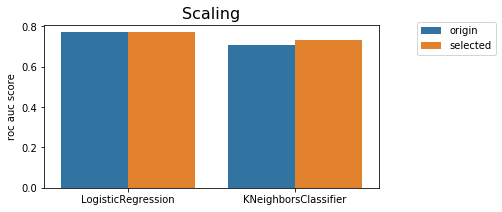

In [16]:
plot_result(r, ['Model', 'Dataset', 'ROC-AUC'])

- LogisticRegression - selected - 0.769478
- KNeighborsClassifier - selected	 - 0.730023
<br> Selected features show the same for LogReg and better for KNN results - further we use dataset with selected features

# Scaling

In [16]:
def scaled(X, scaler_type="minmax"):
    if scaler_type=="minmax":
        scaler = MinMaxScaler()
    elif scaler_type=="std":
        scaler = StandardScaler()
    elif scaler_type=="robust":
        scaler = RobustScaler()
        
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled

,Model,Scaler,ROC-AUC
0,LogisticRegression,minmax,0.769478
1,KNeighborsClassifier,minmax,0.730023
2,LogisticRegression,std,0.793379
3,KNeighborsClassifier,std,0.698367
4,LogisticRegression,robust,0.647159
5,KNeighborsClassifier,robust,0.674467


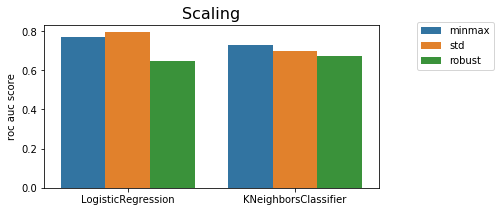

In [18]:
X_train, y_train, X_test, y_test = split(train_selected, test_selected)

result = []
for scaler in ['minmax', 'std', 'robust']:
    for model in [LogisticRegression(), KNeighborsClassifier()]:
        m = model
        name = m.__class__.__name__
        m.fit(scaled(X_train, scaler_type=scaler), y_train)
        prediction = m.predict(scaled(X_test, scaler_type=scaler))
        roc = roc_auc_score(y_test, prediction)
        result.append([name, scaler, roc])

plot_result(result, ['Model', 'Scaler', 'ROC-AUC'])

- LogisticRegression - std - 0.817097
- KNeighborsClassifier - minmax - 0.729977

In [9]:
scaler = {'LogisticRegression': 'std', 'KNeighborsClassifier': 'minmax'}

# Filling NaNs

Since we have to predicted data with possible NaNs, we should pick filling NaNs strategy instead just dropping it. We could fill it by mean, median or mode:

In [11]:
def fill_NA(data, strategy='mean', NA_cols=[]):
    data_copy = data.copy(deep=True)
    for c in NA_cols:
        if data_copy[c].isnull().sum()>0:
            if strategy=='mean':
                data_copy[c] = data_copy[c].fillna(data[c].mean())
            elif strategy=='median':
                data_copy[c] = data_copy[c].fillna(data[c].median())
            elif strategy=='mode':
                data_copy[c] = data_copy[c].fillna(data[c].mode()[0])
    return data_copy

In [13]:
train_nans = train_selected.columns[train_selected.count()<train_selected.shape[0]]
test_nans = test_selected.columns[test_selected.count()<test_selected.shape[0]]

,Model,Filling,ROC-AUC
0,LogisticRegression,None,0.793379
1,KNeighborsClassifier,None,0.730023
2,LogisticRegression,median,0.739488
3,KNeighborsClassifier,median,0.671392
4,LogisticRegression,mode,0.734155
5,KNeighborsClassifier,mode,0.663264
6,LogisticRegression,mean,0.740821
7,KNeighborsClassifier,mean,0.664757


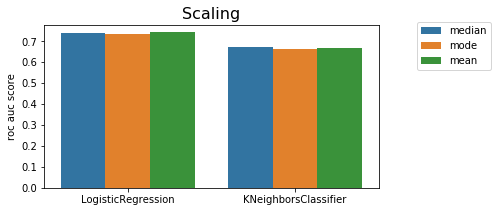

In [20]:
result = []

for fill in [None, 'median', 'mode', 'mean']:
    if fill is None:
        train_wo_nan = train_selected.dropna()
        test_wo_nan = test_selected.dropna()
    else:
        train_wo_nan = fill_NA(train_selected, strategy=fill, NA_cols=train_nans)
        test_wo_nan = fill_NA(test_selected, strategy=fill, NA_cols=test_nans)
    
    X_train, y_train = train_wo_nan.drop('class', axis=1), train_wo_nan['class']
    X_test, y_test = test_wo_nan.drop('class', axis=1), test_wo_nan['class']

    for model in [LogisticRegression(), KNeighborsClassifier()]:
        m = model
        name = m.__class__.__name__
        m.fit(scaled(X_train, scaler_type=scaler[name]), y_train)
        prediction = m.predict(scaled(X_test, scaler_type=scaler[name]))
        roc = roc_auc_score(y_test, prediction)
        result.append([name, fill, roc])

plot_result(result, ['Model', 'Filling', 'ROC-AUC'])

Filling NaNs with statistics slightly drops roc-auc-score both for LogReg, and KNN, but not so dramatically.
<br>The beteter result among filled NaNs for LogReg and KNN is filling with **median**.

In [14]:
train_wo_nan = fill_NA(train_selected, strategy='median', NA_cols=train_nans)
test_wo_nan = fill_NA(test_selected, strategy='median', NA_cols=test_nans)

X_train, y_train = train_wo_nan.drop('class', axis=1), train_wo_nan['class']
X_test, y_test = test_wo_nan.drop('class', axis=1), test_wo_nan['class']

In [17]:
X_train_minmax = scaled(X_train, scaler_type='minmax')
X_test_minmax = scaled(X_test, scaler_type='minmax')

X_train_std = scaled(X_train, scaler_type='std')
X_test_std = scaled(X_test, scaler_type='std')

# GridSearchCV

In [26]:
params = {'LogisticRegression': {'penalty': ['l1', 'l2'],
                                 'C': [0.001, 0.01, 0.1, 1., 10., 100.]},
          'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 9],
                                   'weights': ['uniform', 'distance'], 
                                   'metric': ['euclidean', 'manhattan'],
                                   'leaf_size': [20, 30]}}

In [24]:
m = LogisticRegression()
name = m.__class__.__name__
grid_logreg = GridSearchCV(m, param_grid = params[name])
grid_logreg.fit(X_train_std, y_train)

#Predict values based on new parameters
prediction = grid_logreg.predict(X_test_std)
roc = roc_auc_score(y_test, prediction)

print(f'GridSearchCV LogisticRegression roc auc score {roc} - scaler type is std - fillNA with medians')
print(grid_logreg.best_params_)

GridSearchCV LogisticRegression roc auc score 0.7448213333333332 - scaler type is std - fillNA with medians
{'C': 10.0, 'penalty': 'l1'}


In [27]:
m = KNeighborsClassifier()
name = m.__class__.__name__
grid_knn = GridSearchCV(m, param_grid = params[name])
grid_knn.fit(X_train_minmax, y_train)

prediction = grid_knn.predict(X_test_minmax)
roc = roc_auc_score(y_test, prediction)

print(f'GridSearchCV KNeighborsClassifier roc auc score {roc} - scaler type is minmax - fillNA with medians')
print(grid_knn.best_params_)

GridSearchCV KNeighborsClassifier roc auc score 0.68752 - scaler type is minmax - fillNA with medians
{'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
